# Installing dependencies

In [3]:
!pip3 install tensorflow pandas matplotlib scikit-learn

In [4]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [5]:
df = pd.read_csv(
    os.path.join('jigsaw-toxic-comment-classification-challenge', 'train.csv')
)

In [6]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Preprocessing Data

In [7]:
from tensorflow.keras.layers import TextVectorization

In [8]:
x = df['comment_text']
y = df[df.columns[2:]].values

In [12]:
MAX_FEATURES = 200000 # numbers of words in model

In [13]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                                output_sequence_length=1500,
                                output_mode='int')

In [15]:
vectorizer.adapt(x.values)

In [16]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [17]:
vectorized_text = vectorizer(x.values)

In [18]:
vectorized_text

<tf.Tensor: shape=(159571, 1500), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [22]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [23]:
batch_x.shape

(16, 1500)

In [24]:
batch_y.shape

(16, 6)

In [25]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [26]:
train_generator = train.as_numpy_iterator()

In [29]:
train_generator.next()

(array([[   29,    45,    28, ...,     0,     0,     0],
        [  451, 27492,  2557, ...,     0,     0,     0],
        [   45,    28, 10219, ...,     0,     0,     0],
        ...,
        [  126,    45,    28, ...,     0,     0,     0],
        [ 1419,  1051,   635, ...,     0,     0,     0],
        [   30,   310,     4, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0]]))

## Sequential Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [34]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

In [35]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
5439/6981 [======================>.......] - ETA: 50:13 - loss: 0.0462

In [38]:
from matplotlib import pyplot as plt

<Figure size 600x500 with 0 Axes>

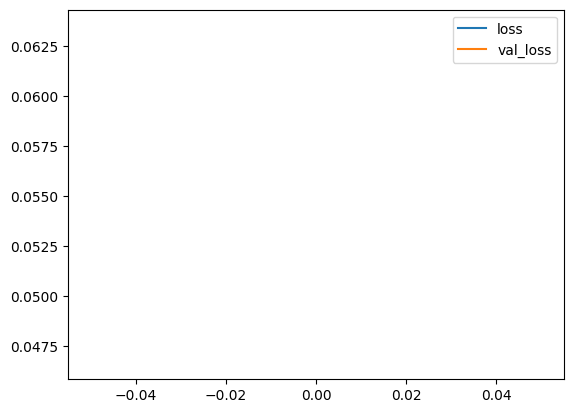

In [41]:
plt.figure(figsize=(6,5))
pd.DataFrame(history.history).plot()
plt.show()

## Predictions

In [44]:
input_text = vectorizer('You suck! I am going to hurt you.')

In [46]:
batch = test.as_numpy_iterator().next()

In [47]:
batch_X, batch_Y = test.as_numpy_iterator().next()

In [48]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 42ms/step


array([[0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [50]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 25ms/step


## Evaluate Model

In [51]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [52]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [55]:
for batch in test.as_numpy_iterator():
    X_true, Y_true = batch
    yhat = model.predict(X_true)

    Y_true = Y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(Y_true, yhat)
    re.update_state(Y_true, yhat)
    acc.update_state(Y_true, yhat)

1/1 [==============================] - 0s 28ms/step


In [59]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.829150915145874, Recall: 0.6771476864814758, Accuracy: 0.5015045404434204
